# Projet Fixmatch

In [1]:
!pip install torchview torchsummary torchvision kornia torchmetrics matplotlib tqdm path graphviz opencv-python scikit-learn optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 653.4/653.4 kB 14.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 69.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 68.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 MB 46.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 84.8 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 3.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.7/300.7 kB 51.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 43.4 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 117.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4

In [2]:
# deep learning
import torch
import torch.nn as nn
from torch.distributions.transforms import LowerCholeskyTransform
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.data import DataLoader, Dataset

# vizualisation
import torchsummary

# transforms
import torchvision.transforms as T
import kornia.augmentation as K
from kornia.enhance import normalize
# from torchvision.transforms import RandAugment

# metrics
from torchmetrics import Accuracy

# torchvision
import torchvision
from torchvision import transforms

# plotting
import matplotlib.pyplot as plt
from torchview import draw_graph

from IPython.display import display
from IPython.core.display import SVG, HTML

from tqdm.auto import tqdm

# typing
from typing import Callable

from utils import plot_images, plot_transform
from model import ConvNN, display_model

# os
import os
import path

import random
import numpy as np 

# transformations
# import transform as T
# from randaugment import RandomAugment

# typing
from typing import Callable, List, Tuple

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics.pairwise import cosine_similarity

from randaugment import RandAugmentMC

%load_ext autoreload
%autoreload 2

In [3]:
DEFAULT_RANDOM_SEED = 2021

def seedBasic(seed=DEFAULT_RANDOM_SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
# torch random seed
import torch
def seedTorch(seed=DEFAULT_RANDOM_SEED):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
      
# basic + tensorflow + torch 
def seedEverything(seed=DEFAULT_RANDOM_SEED):
    seedBasic(seed)
    seedTorch(seed)

In [4]:
# Set device
if ((int(torch.__version__.split(".")[0]) >= 2) or (int(torch.__version__.split(".")[1]) >= 13)) and torch.has_mps:
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

cuda


In [5]:
IMG_SHAPE = (3, 32, 32)
# See Table 4
TAU = 0.95 #! 0.95 in the paper
LAMBDA_U = 1
MU = 7
BATCH_SIZE = 64
LR = 0.03
BETA = 0.9
WEIGHT_DECAY = 0.001
BETA_DENSITY = 1

In [6]:
class ConvNN(nn.Module):
    """
    Simple CNN for CIFAR10
    """
    
    def __init__(self):
        super().__init__()
        self.conv_32 = nn.Conv2d(3, 32, kernel_size=3, padding='same')
        self.conv_64 = nn.Conv2d(32, 64, kernel_size=3, padding='same')
        self.conv_96 = nn.Conv2d(64, 96, kernel_size=3, padding='same')
        self.conv_128 = nn.Conv2d(96, 128, kernel_size=3, padding='same')
        self.fc_512 = nn.Linear(512, 512)
        self.fc_10 = nn.Linear(512, 10)
        self.max_pool = nn.MaxPool2d(2)
        self.relu = nn.ReLU(inplace=True)
        self.flatten = nn.Flatten()
        # self.softmax = nn.Softmax(dim=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv_32(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.conv_64(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.conv_96(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.conv_128(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.flatten(x)
        x = self.fc_512(x)
        x = self.relu(x)
        x = self.fc_10(x)
        # x = self.softmax(x)

        return x

In [7]:
def compute_mean_std(trainLoader) -> Tuple[List[float], List[float]]:
    # initialize the list of means and stds
    mean, std = torch.zeros(3), torch.zeros(3)

    # iterate over the dataset and compute the sum of each channel
    for images, _ in trainLoader:
        mean+= torch.mean(images, dim=[0,2,3])
        std+= torch.std(images, dim=[0,2,3])
    
    # compute the mean and std
    mean = mean/len(trainLoader)
    std = std/len(trainLoader)

    return mean, std

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

if not os.path.exists('./data/mean.pt'):
    mean, std = compute_mean_std(trainloader)
    torch.save(mean, 'data/mean.pt')
    torch.save(std, 'data/std.pt')
else:
    mean, std = torch.load('./data/mean.pt'), torch.load('./data/std.pt')

# to numpy
mean, std = mean.numpy(), std.numpy()

print(f"mean: {mean}, std: {std}")


testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
mean: [0.4913966  0.48215377 0.44651437], std: [0.246344   0.24280126 0.26067406]
Files already downloaded and verified


In [8]:
torch_models = 'torch_models' 
if not os.path.exists(torch_models):
    os.makedirs(torch_models)

## IV. Semi-Supervised Learning: Fixmatch with Active Learning

### IV.1 Fixmatch on 10% train data with Active Learning

In [9]:
# Define your dataset and dataloaders for labeled and unlabeled data
seedEverything()

TARGET_PROP = 0.05
EPOCHS = 300
SUBSET_PROP = 0.005
K_SAMPLES = 50

# 10% labeled data and 100% unlabeled (see note 2 in paper)
trainset_sup, _ = torch.utils.data.random_split(trainset, [SUBSET_PROP, 1-SUBSET_PROP])

trainset_unsup, _ = torch.utils.data.random_split(trainset, [1, 0])

labeled_dataloader = DataLoader(
    trainset_sup,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

unlabeled_dataloader = DataLoader(
    trainset_unsup,
    batch_size=MU*BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataset.py:348: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


In [10]:
# transformations
weak_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=0, translate=(0.125, 0.125)),
    # transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

strong_transform = transforms.Compose([
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomAffine(degrees=10, translate=(0.125, 0.125)),
    # transforms.RandAugment(num_ops=2, magnitude=10),
    RandAugmentMC(n=2, m=10),
    # transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
    

In [11]:
def mask(model, weak_unlabeled_data):
    with torch.no_grad():
        model.train()

        qb = model(weak_unlabeled_data)

        # qb = logits.copy()
        qb = torch.softmax(qb, dim=1)

        max_qb, qb_hat_max = torch.max(qb, dim=1)
        

        idx_max = max_qb >= TAU
        qb_hat_max = qb_hat_max[idx_max]



    return qb_hat_max.detach(), idx_max, max_qb.detach()

In [12]:
model = ConvNN().to(device)

# criterion and optimizer
labeled_criterion = nn.CrossEntropyLoss(reduction='none')
unlabeled_criterion = nn.CrossEntropyLoss(reduction='none')
true_unlabeled_criterion = nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=BETA, weight_decay=WEIGHT_DECAY, nesterov=True)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

In [13]:
from joblib import Parallel, delayed

In [14]:

def compute_qb_transformed(inputs, i, K_transform=2):
    inputs = inputs.unsqueeze(0).to(device)
    qb_transformed_i = torch.zeros((K_transform, 10))
    
    for k in range(K_transform):
        # compute weak transformation of inputs norm
        weak_transformed_inputs = weak_transform(inputs)

        # compute predictions of weak transformed inputs norm
        logits = model(weak_transformed_inputs)
        qb = torch.softmax(logits, dim=1)

        # store
        qb_transformed_i[k] = qb
    
    # compute mean over K_transform and remove dimension
    qb_transformed_i = torch.mean(qb_transformed_i, dim=0)
    qb_transformed_i = qb_transformed_i.squeeze(0)
    
    return i, qb_transformed_i

In [15]:
def information_density(
    model: ConvNN, 
    trainset_unsup: torch.utils.data.Dataset,
    k_samp: int,
    K_transform: int = 2) -> torch.Tensor:

    # create a random uniform subsample of trainset_unsup
    trainset_unsup_sample = torch.utils.data.Subset(trainset_unsup, np.random.choice(len(trainset_unsup), len(trainset_unsup)//10, replace=False))

    # retrieve indices of sample trainset_unsup
    trainset_unsup_sample_indices = trainset_unsup_sample.indices

    model.eval()

    qb_transformed = torch.zeros((len(trainset_unsup_sample), 10))
    print('Active Learning step... ')
    with torch.no_grad():
        results = Parallel(n_jobs=-1)(
            delayed(compute_qb_transformed)(inputs, i, K_transform)
            for i, (inputs, _) in tqdm(enumerate(trainset_unsup_sample))
        )

        for i, qb_transformed_i in results:
            qb_transformed[i] = qb_transformed_i

        # get top 2 values of qb
        qb1, qb2 = torch.topk(qb_transformed, k=2, dim=1, sorted=True)[0][:, 0], torch.topk(qb_transformed, k=2, dim=1, sorted=True)[0][:, 1]

        uncertainty = 1 - (qb1 - qb2)

        # get top k_samp indices
        _, idx = torch.topk(uncertainty, k=k_samp, dim=0, sorted=True)

        # compute true indices
        idx_true = torch.tensor(trainset_unsup_sample_indices)[idx]

    return idx_true, torch.mean(uncertainty).item()

def least_confidence(
    model: ConvNN,
    unlabeled_dataloader: torch.utils.data.DataLoader,
    k_samp: int) -> torch.Tensor:
    
    probs = []
    model.eval()

    with torch.no_grad():
        for i, (inputs, _) in enumerate(unlabeled_dataloader):
            inputs = inputs.to(device)

            # inputs transforms
            weak_transformed_inputs = weak_transform(inputs)

            logits = model(weak_transformed_inputs)
            qb = torch.softmax(logits, dim=1)
            probs.append(qb.cpu().data)
    
    # transform to tensor
    probs_tensor = torch.cat(probs, dim=0)

    U = probs_tensor.max(1)[0]

    selected_indices = U.sort()[1][:k_samp]

    return selected_indices, torch.mean(torch.sort(U, descending=False)[0][:k_samp]).item()


# Create a new labeled dataset using active learning
def create_labeled_dataset_active_learning(dataset, selected_indices):
    dataset = torch.utils.data.Subset(dataset, selected_indices)
    return dataset

In [16]:
print("Start training")
CIFAR10_class_distribution = 0.10

current_prop = SUBSET_PROP

train_losses = []
test_losses = []
added_samp = 0
uncertainty = 0

for j in range(EPOCHS):
    model.train()

    running_loss = 0.0
    correct = 0
    total = 0
    running_n_unlabeled = 0
    moving_avg_pred_labeled = 0
    moving_avg_pred_unlabeled = 0

    pbar = tqdm(zip(labeled_dataloader, unlabeled_dataloader), total=min(len(labeled_dataloader), len(unlabeled_dataloader)), unit="batch", desc=f"Epoch {j: >5}")

    for i, (labeled_data, unlabeled_data) in enumerate(pbar):
        # Get labeled and unlabeled data
        labeled_inputs, labels = labeled_data[0].to(device), labeled_data[1].to(device)
        unlabeled_inputs, _ = unlabeled_data[0].to(device), unlabeled_data[1].to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # normalize labeled and unlabeled inputs
        labeled_inputs_norm, unlabeled_inputs_norm = normalize(labeled_inputs, mean, std), normalize(unlabeled_inputs, mean, std)

        # labeled_outputs_norm = model(labeled_inputs_norm)
        unlabeled_outputs_norm = model(unlabeled_inputs_norm)

        # Compute moving average of labeled and unlabeled predictions
        moving_avg_pred_unlabeled = (i * moving_avg_pred_unlabeled + unlabeled_outputs_norm.shape[0]) / (i + 1)

        # ratio
        ratio = CIFAR10_class_distribution / moving_avg_pred_unlabeled

        # Apply weak augmentation to labeled data
        weak_labeled_inputs = weak_transform(labeled_inputs)

        # Apply strong augmentation + weak augmentation to unlabeled data
        weak_unlabeled_inputs = weak_transform(unlabeled_inputs)
        strong_unlabeled_inputs = strong_transform(unlabeled_inputs)

        # prediction on weak augmented unlabeled data
        qb = model(weak_unlabeled_inputs)
        qb = torch.softmax(qb, dim=1)
        qb_norm = qb * ratio

        # normalize
        qb_tilde = qb_norm / torch.sum(qb_norm, dim=1, keepdim=True)

        # compute mask
        max_qb_tilde, qb_tilde_hat = torch.max(qb_tilde, dim=1)
        idx = max_qb_tilde > TAU

        # pseudo labels
        pseudo_labels = qb_tilde_hat[idx]

       # mask strong augmented unlabeled data
        strong_unlabeled_inputs = strong_unlabeled_inputs[idx]

        n_labeled, n_unlabeled = weak_labeled_inputs.size(0), strong_unlabeled_inputs.size(0)

        if n_unlabeled != 0:
            # Concatenate labeled and unlabeled data
            inputs_all = torch.cat((weak_labeled_inputs, strong_unlabeled_inputs))
            labels_all = torch.cat((labels, pseudo_labels))

            # forward pass
            outputs = model(inputs_all)

            # split labeled and unlabeled outputs
            labeled_outputs, unlabeled_outputs = outputs[:n_labeled], outputs[n_labeled:]

            # compute losses
            labeled_loss = torch.sum(labeled_criterion(labeled_outputs, labels)) / BATCH_SIZE
            unlabeled_loss = torch.sum(unlabeled_criterion(unlabeled_outputs, pseudo_labels)) / (MU * BATCH_SIZE)
            
            # true_unlabeled_loss = torch.sum(true_unlabeled_criterion(unlabeled_outputs, unlabeled_labels)) / (MU * BATCH_SIZE)

            # compute total loss
            loss = labeled_loss + LAMBDA_U * unlabeled_loss

            # compute accuracy
            total += labels_all.size(0)
            correct += (outputs.argmax(dim=1) == labels_all).sum().item()
            
        else:
            # forward pass
            labeled_outputs = model(weak_labeled_inputs)

            # compute loss
            labeled_loss = torch.sum(labeled_criterion(labeled_outputs, labels)) / BATCH_SIZE
            unlabeled_loss = torch.tensor(0, device=device)

            # compute total loss
            loss = labeled_loss + LAMBDA_U * unlabeled_loss

            # compute accuracy
            total += labels.size(0)
            correct += (labeled_outputs.argmax(dim=1) == labels).sum().item()
            

        # backward pass + optimize
        loss.backward()
        optimizer.step()

        # clamp gradients, just in case
        # for p in filter(lambda p: p.grad is not None, model.parameters()): p.grad.data.clamp_(min=-.1, max=.1)
        
        

        
        # update statistics
        running_loss += loss.item()
        running_n_unlabeled += n_unlabeled 

        # update progress bar
        pbar.set_postfix({
            "labeled loss": labeled_loss.item(),
            "unlabeled loss": unlabeled_loss.item(),
            "accuracy": 100 * correct / total,
            "avg confidence": torch.mean(max_qb_tilde).item(),
            "n_unlabeled": running_n_unlabeled,
            "current_prop": current_prop,
            "uncertainty": uncertainty,
            "lr": optimizer.param_groups[0]['lr']
        })

    # start adding labels after 50 epochs for 50 epochs
    if current_prop < TARGET_PROP and j%3==0:
        # compute information density
        selected_indices, uncertainty = information_density(model, trainset_unsup, K_SAMPLES)

        # select indices from unlabeled dataset
        trainset_sup_new = create_labeled_dataset_active_learning(trainset_unsup, selected_indices)

        # concat new trainset with labeled trainset
        trainset_sup = torch.utils.data.ConcatDataset([trainset_sup, trainset_sup_new])

        # create labeled dataloader
        labeled_dataloader = torch.utils.data.DataLoader(trainset_sup, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

        current_prop = len(trainset_sup) / len(trainset)
    

    # update loss
    train_losses.append(running_loss / (i + 1))

    # scheduler step
    if scheduler is not None:
        scheduler.step()

    # if n_unlabeled != 0:
    #     # plot an image of the batch
    #     image = strong_unlabeled_inputs[0].cpu()
    #     # image = image * std + mean
    #     image = image.permute(1, 2, 0).cpu().numpy() * std + mean
    #     plt.imshow(image)
    #     plt.title(f'Pred: {unlabeled_outputs.argmax(dim=1)[0]}, true: {unlabeled_labels[0]}')
    #     plt.show()

    
    # Evaluate the model on the test set
    model.eval()  # Set the model to evaluation mode
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # normalize
            images = normalize(data=images, mean=mean, std=std)
            
            outputs = model(images)
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()
        
        test_accuracy = 100.0 * test_correct / test_total
        print(f'Test Accuracy: {test_accuracy}%')

        # update loss
        test_losses.append(torch.sum(labeled_criterion(outputs, labels)).item() / BATCH_SIZE)

Start training


Epoch     0:   0%|          | 0/4 [00:00<?, ?batch/s]

Active Learning step... 


0it [00:00, ?it/s]

Test Accuracy: 10.04%


Epoch     1:   0%|          | 0/5 [00:00<?, ?batch/s]

Test Accuracy: 10.53%


Epoch     2:   0%|          | 0/5 [00:00<?, ?batch/s]

Test Accuracy: 15.28%


Epoch     3:   0%|          | 0/5 [00:00<?, ?batch/s]

Active Learning step... 


0it [00:00, ?it/s]

Test Accuracy: 10.0%


Epoch     4:   0%|          | 0/6 [00:00<?, ?batch/s]

Test Accuracy: 14.4%


Epoch     5:   0%|          | 0/6 [00:00<?, ?batch/s]

Test Accuracy: 15.51%


Epoch     6:   0%|          | 0/6 [00:00<?, ?batch/s]

Active Learning step... 


0it [00:00, ?it/s]

Test Accuracy: 15.85%


Epoch     7:   0%|          | 0/7 [00:00<?, ?batch/s]

Test Accuracy: 19.17%


Epoch     8:   0%|          | 0/7 [00:00<?, ?batch/s]

Test Accuracy: 21.36%


Epoch     9:   0%|          | 0/7 [00:00<?, ?batch/s]

Active Learning step... 


0it [00:00, ?it/s]

Test Accuracy: 20.72%


Epoch    10:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 21.08%


Epoch    11:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 20.06%


Epoch    12:   0%|          | 0/8 [00:00<?, ?batch/s]

Active Learning step... 


0it [00:00, ?it/s]

Test Accuracy: 25.73%


Epoch    13:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 26.82%


Epoch    14:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 25.13%


Epoch    15:   0%|          | 0/8 [00:00<?, ?batch/s]

Active Learning step... 


0it [00:00, ?it/s]

Test Accuracy: 24.36%


Epoch    16:   0%|          | 0/9 [00:00<?, ?batch/s]

Test Accuracy: 29.58%


Epoch    17:   0%|          | 0/9 [00:00<?, ?batch/s]

Test Accuracy: 24.7%


Epoch    18:   0%|          | 0/9 [00:00<?, ?batch/s]

Active Learning step... 


0it [00:00, ?it/s]

Test Accuracy: 27.58%


Epoch    19:   0%|          | 0/10 [00:00<?, ?batch/s]

Test Accuracy: 29.56%


Epoch    20:   0%|          | 0/10 [00:00<?, ?batch/s]

Test Accuracy: 30.77%


Epoch    21:   0%|          | 0/10 [00:00<?, ?batch/s]

Active Learning step... 


0it [00:00, ?it/s]

Test Accuracy: 31.03%


Epoch    22:   0%|          | 0/11 [00:00<?, ?batch/s]

Test Accuracy: 29.52%


Epoch    23:   0%|          | 0/11 [00:00<?, ?batch/s]

Test Accuracy: 36.7%


Epoch    24:   0%|          | 0/11 [00:00<?, ?batch/s]

Active Learning step... 


0it [00:00, ?it/s]

Test Accuracy: 35.67%


Epoch    25:   0%|          | 0/11 [00:00<?, ?batch/s]

Test Accuracy: 27.34%


Epoch    26:   0%|          | 0/11 [00:00<?, ?batch/s]

Test Accuracy: 21.36%


Epoch    27:   0%|          | 0/11 [00:00<?, ?batch/s]

Active Learning step... 


0it [00:00, ?it/s]

Test Accuracy: 32.98%


Epoch    28:   0%|          | 0/12 [00:00<?, ?batch/s]

Test Accuracy: 30.82%


Epoch    29:   0%|          | 0/12 [00:00<?, ?batch/s]

Test Accuracy: 38.68%


Epoch    30:   0%|          | 0/12 [00:00<?, ?batch/s]

Active Learning step... 


0it [00:00, ?it/s]

Test Accuracy: 38.86%


Epoch    31:   0%|          | 0/13 [00:00<?, ?batch/s]

Test Accuracy: 36.47%


Epoch    32:   0%|          | 0/13 [00:00<?, ?batch/s]

Test Accuracy: 37.24%


Epoch    33:   0%|          | 0/13 [00:00<?, ?batch/s]

Active Learning step... 


0it [00:00, ?it/s]

Test Accuracy: 35.98%


Epoch    34:   0%|          | 0/14 [00:00<?, ?batch/s]

Test Accuracy: 37.1%


Epoch    35:   0%|          | 0/14 [00:00<?, ?batch/s]

Test Accuracy: 38.8%


Epoch    36:   0%|          | 0/14 [00:00<?, ?batch/s]

Active Learning step... 


0it [00:00, ?it/s]

Test Accuracy: 36.94%


Epoch    37:   0%|          | 0/15 [00:00<?, ?batch/s]

Test Accuracy: 40.12%


Epoch    38:   0%|          | 0/15 [00:00<?, ?batch/s]

Test Accuracy: 41.05%


Epoch    39:   0%|          | 0/15 [00:00<?, ?batch/s]

Active Learning step... 


0it [00:00, ?it/s]

Test Accuracy: 38.99%


Epoch    40:   0%|          | 0/15 [00:00<?, ?batch/s]

Test Accuracy: 36.35%


Epoch    41:   0%|          | 0/15 [00:00<?, ?batch/s]

Test Accuracy: 41.05%


Epoch    42:   0%|          | 0/15 [00:00<?, ?batch/s]

Active Learning step... 


0it [00:00, ?it/s]

Test Accuracy: 37.82%


Epoch    43:   0%|          | 0/16 [00:00<?, ?batch/s]

Test Accuracy: 40.43%


Epoch    44:   0%|          | 0/16 [00:00<?, ?batch/s]

Test Accuracy: 41.93%


Epoch    45:   0%|          | 0/16 [00:00<?, ?batch/s]

Active Learning step... 


0it [00:00, ?it/s]

Test Accuracy: 42.34%


Epoch    46:   0%|          | 0/17 [00:00<?, ?batch/s]

Test Accuracy: 43.85%


Epoch    47:   0%|          | 0/17 [00:00<?, ?batch/s]

Test Accuracy: 39.51%


Epoch    48:   0%|          | 0/17 [00:00<?, ?batch/s]

Active Learning step... 


0it [00:00, ?it/s]

Test Accuracy: 42.88%


Epoch    49:   0%|          | 0/18 [00:00<?, ?batch/s]

Test Accuracy: 45.57%


Epoch    50:   0%|          | 0/18 [00:00<?, ?batch/s]

Test Accuracy: 43.1%


Epoch    51:   0%|          | 0/18 [00:00<?, ?batch/s]

Active Learning step... 


0it [00:00, ?it/s]

Test Accuracy: 45.68%


Epoch    52:   0%|          | 0/18 [00:00<?, ?batch/s]

Test Accuracy: 47.72%


Epoch    53:   0%|          | 0/18 [00:00<?, ?batch/s]

Test Accuracy: 45.59%


Epoch    54:   0%|          | 0/18 [00:00<?, ?batch/s]

Active Learning step... 


0it [00:00, ?it/s]

Test Accuracy: 47.0%


Epoch    55:   0%|          | 0/19 [00:00<?, ?batch/s]

Test Accuracy: 46.02%


Epoch    56:   0%|          | 0/19 [00:00<?, ?batch/s]

Test Accuracy: 47.34%


Epoch    57:   0%|          | 0/19 [00:00<?, ?batch/s]

Active Learning step... 


0it [00:00, ?it/s]

Test Accuracy: 48.08%


Epoch    58:   0%|          | 0/20 [00:00<?, ?batch/s]

Test Accuracy: 45.95%


Epoch    59:   0%|          | 0/20 [00:00<?, ?batch/s]

Test Accuracy: 47.32%


Epoch    60:   0%|          | 0/20 [00:00<?, ?batch/s]

Active Learning step... 


0it [00:00, ?it/s]

Test Accuracy: 48.27%


Epoch    61:   0%|          | 0/21 [00:00<?, ?batch/s]

Test Accuracy: 49.01%


Epoch    62:   0%|          | 0/21 [00:00<?, ?batch/s]

Test Accuracy: 48.36%


Epoch    63:   0%|          | 0/21 [00:00<?, ?batch/s]

Active Learning step... 


0it [00:00, ?it/s]

Test Accuracy: 49.72%


Epoch    64:   0%|          | 0/22 [00:00<?, ?batch/s]

Test Accuracy: 50.36%


Epoch    65:   0%|          | 0/22 [00:00<?, ?batch/s]

Test Accuracy: 49.25%


Epoch    66:   0%|          | 0/22 [00:00<?, ?batch/s]

Active Learning step... 


0it [00:00, ?it/s]

Test Accuracy: 44.17%


Epoch    67:   0%|          | 0/22 [00:00<?, ?batch/s]

Test Accuracy: 50.3%


Epoch    68:   0%|          | 0/22 [00:00<?, ?batch/s]

Test Accuracy: 49.24%


Epoch    69:   0%|          | 0/22 [00:00<?, ?batch/s]

Active Learning step... 


0it [00:00, ?it/s]

Test Accuracy: 47.79%


Epoch    70:   0%|          | 0/23 [00:00<?, ?batch/s]

Test Accuracy: 49.64%


Epoch    71:   0%|          | 0/23 [00:00<?, ?batch/s]

Test Accuracy: 51.04%


Epoch    72:   0%|          | 0/23 [00:00<?, ?batch/s]

Active Learning step... 


0it [00:00, ?it/s]

Test Accuracy: 49.56%


Epoch    73:   0%|          | 0/24 [00:00<?, ?batch/s]

Test Accuracy: 52.5%


Epoch    74:   0%|          | 0/24 [00:00<?, ?batch/s]

Test Accuracy: 49.83%


Epoch    75:   0%|          | 0/24 [00:00<?, ?batch/s]

Active Learning step... 


0it [00:00, ?it/s]

Test Accuracy: 49.57%


Epoch    76:   0%|          | 0/25 [00:00<?, ?batch/s]

Test Accuracy: 51.92%


Epoch    77:   0%|          | 0/25 [00:00<?, ?batch/s]

Test Accuracy: 50.91%


Epoch    78:   0%|          | 0/25 [00:00<?, ?batch/s]

Active Learning step... 


0it [00:00, ?it/s]

Test Accuracy: 49.15%


Epoch    79:   0%|          | 0/25 [00:00<?, ?batch/s]

Test Accuracy: 51.21%


Epoch    80:   0%|          | 0/25 [00:00<?, ?batch/s]

Test Accuracy: 51.95%


Epoch    81:   0%|          | 0/25 [00:00<?, ?batch/s]

Active Learning step... 


0it [00:00, ?it/s]

Test Accuracy: 53.24%


Epoch    82:   0%|          | 0/26 [00:00<?, ?batch/s]

Test Accuracy: 51.27%


Epoch    83:   0%|          | 0/26 [00:00<?, ?batch/s]

Test Accuracy: 53.73%


Epoch    84:   0%|          | 0/26 [00:00<?, ?batch/s]

Active Learning step... 


0it [00:00, ?it/s]

Test Accuracy: 52.54%


Epoch    85:   0%|          | 0/27 [00:00<?, ?batch/s]

Test Accuracy: 53.18%


Epoch    86:   0%|          | 0/27 [00:00<?, ?batch/s]

Test Accuracy: 54.05%


Epoch    87:   0%|          | 0/27 [00:00<?, ?batch/s]

Active Learning step... 


0it [00:00, ?it/s]

Test Accuracy: 53.22%


Epoch    88:   0%|          | 0/28 [00:00<?, ?batch/s]

Test Accuracy: 52.23%


Epoch    89:   0%|          | 0/28 [00:00<?, ?batch/s]

Test Accuracy: 55.79%


Epoch    90:   0%|          | 0/28 [00:00<?, ?batch/s]

Active Learning step... 


0it [00:00, ?it/s]

Test Accuracy: 53.27%


Epoch    91:   0%|          | 0/29 [00:00<?, ?batch/s]

Test Accuracy: 54.59%


Epoch    92:   0%|          | 0/29 [00:00<?, ?batch/s]

Test Accuracy: 54.57%


Epoch    93:   0%|          | 0/29 [00:00<?, ?batch/s]

Active Learning step... 


0it [00:00, ?it/s]

Test Accuracy: 55.26%


Epoch    94:   0%|          | 0/29 [00:00<?, ?batch/s]

Test Accuracy: 56.05%


Epoch    95:   0%|          | 0/29 [00:00<?, ?batch/s]

Test Accuracy: 55.94%


Epoch    96:   0%|          | 0/29 [00:00<?, ?batch/s]

Active Learning step... 


0it [00:00, ?it/s]

Test Accuracy: 55.82%


Epoch    97:   0%|          | 0/30 [00:00<?, ?batch/s]

Test Accuracy: 52.45%


Epoch    98:   0%|          | 0/30 [00:00<?, ?batch/s]

Test Accuracy: 56.85%


Epoch    99:   0%|          | 0/30 [00:00<?, ?batch/s]

Active Learning step... 


0it [00:00, ?it/s]

Test Accuracy: 54.93%


Epoch   100:   0%|          | 0/31 [00:00<?, ?batch/s]

Test Accuracy: 56.75%


Epoch   101:   0%|          | 0/31 [00:00<?, ?batch/s]

Test Accuracy: 55.92%


Epoch   102:   0%|          | 0/31 [00:00<?, ?batch/s]

Active Learning step... 


0it [00:00, ?it/s]

Test Accuracy: 56.06%


Epoch   103:   0%|          | 0/32 [00:00<?, ?batch/s]

Test Accuracy: 56.17%


Epoch   104:   0%|          | 0/32 [00:00<?, ?batch/s]

Test Accuracy: 57.3%


Epoch   105:   0%|          | 0/32 [00:00<?, ?batch/s]

Active Learning step... 


0it [00:00, ?it/s]

Test Accuracy: 56.97%


Epoch   106:   0%|          | 0/33 [00:00<?, ?batch/s]

Test Accuracy: 57.82%


Epoch   107:   0%|          | 0/33 [00:00<?, ?batch/s]

Test Accuracy: 58.38%


Epoch   108:   0%|          | 0/33 [00:00<?, ?batch/s]

Active Learning step... 


0it [00:00, ?it/s]

Test Accuracy: 59.1%


Epoch   109:   0%|          | 0/33 [00:00<?, ?batch/s]

Test Accuracy: 57.84%


Epoch   110:   0%|          | 0/33 [00:00<?, ?batch/s]

Test Accuracy: 57.68%


Epoch   111:   0%|          | 0/33 [00:00<?, ?batch/s]

Active Learning step... 


0it [00:00, ?it/s]

Test Accuracy: 58.26%


Epoch   112:   0%|          | 0/34 [00:00<?, ?batch/s]

Test Accuracy: 60.28%


Epoch   113:   0%|          | 0/34 [00:00<?, ?batch/s]

Test Accuracy: 60.11%


Epoch   114:   0%|          | 0/34 [00:00<?, ?batch/s]

Active Learning step... 


0it [00:00, ?it/s]

Test Accuracy: 60.09%


Epoch   115:   0%|          | 0/35 [00:00<?, ?batch/s]

Test Accuracy: 60.43%


Epoch   116:   0%|          | 0/35 [00:00<?, ?batch/s]

Test Accuracy: 58.85%


Epoch   117:   0%|          | 0/35 [00:00<?, ?batch/s]

Active Learning step... 


0it [00:00, ?it/s]

Test Accuracy: 60.36%


Epoch   118:   0%|          | 0/36 [00:00<?, ?batch/s]

Test Accuracy: 60.44%


Epoch   119:   0%|          | 0/36 [00:00<?, ?batch/s]

Test Accuracy: 60.87%


Epoch   120:   0%|          | 0/36 [00:00<?, ?batch/s]

Active Learning step... 


0it [00:00, ?it/s]

Test Accuracy: 58.7%


Epoch   121:   0%|          | 0/36 [00:00<?, ?batch/s]

Test Accuracy: 60.54%


Epoch   122:   0%|          | 0/36 [00:00<?, ?batch/s]

Test Accuracy: 61.18%


Epoch   123:   0%|          | 0/36 [00:00<?, ?batch/s]

Active Learning step... 


0it [00:00, ?it/s]

Test Accuracy: 60.3%


Epoch   124:   0%|          | 0/37 [00:00<?, ?batch/s]

Test Accuracy: 61.31%


Epoch   125:   0%|          | 0/37 [00:00<?, ?batch/s]

Test Accuracy: 61.03%


Epoch   126:   0%|          | 0/37 [00:00<?, ?batch/s]

Active Learning step... 


0it [00:00, ?it/s]

Test Accuracy: 61.27%


Epoch   127:   0%|          | 0/38 [00:00<?, ?batch/s]

Test Accuracy: 60.5%


Epoch   128:   0%|          | 0/38 [00:00<?, ?batch/s]

Test Accuracy: 61.52%


Epoch   129:   0%|          | 0/38 [00:00<?, ?batch/s]

Active Learning step... 


0it [00:00, ?it/s]

Test Accuracy: 62.47%


Epoch   130:   0%|          | 0/39 [00:00<?, ?batch/s]

Test Accuracy: 61.84%


Epoch   131:   0%|          | 0/39 [00:00<?, ?batch/s]

Test Accuracy: 62.06%


Epoch   132:   0%|          | 0/39 [00:00<?, ?batch/s]

Active Learning step... 


0it [00:00, ?it/s]

Test Accuracy: 61.43%


Epoch   133:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 63.0%


Epoch   134:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 61.41%


Epoch   135:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 62.2%


Epoch   136:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 62.35%


Epoch   137:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 63.12%


Epoch   138:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 62.35%


Epoch   139:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 63.49%


Epoch   140:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 64.44%


Epoch   141:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 63.64%


Epoch   142:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 64.68%


Epoch   143:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 63.95%


Epoch   144:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 63.37%


Epoch   145:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 62.82%


Epoch   146:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 63.86%


Epoch   147:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 64.21%


Epoch   148:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 64.52%


Epoch   149:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 64.27%


Epoch   150:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 64.79%


Epoch   151:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 64.48%


Epoch   152:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 65.01%


Epoch   153:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 64.7%


Epoch   154:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 64.41%


Epoch   155:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 64.45%


Epoch   156:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 66.03%


Epoch   157:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 65.23%


Epoch   158:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 65.53%


Epoch   159:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 65.87%


Epoch   160:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 65.47%


Epoch   161:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 66.16%


Epoch   162:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 66.83%


Epoch   163:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 65.73%


Epoch   164:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 66.65%


Epoch   165:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 65.83%


Epoch   166:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 65.66%


Epoch   167:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 66.84%


Epoch   168:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 66.59%


Epoch   169:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 67.05%


Epoch   170:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 66.67%


Epoch   171:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 67.25%


Epoch   172:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 67.13%


Epoch   173:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 66.75%


Epoch   174:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 67.61%


Epoch   175:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 67.35%


Epoch   176:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 66.52%


Epoch   177:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 66.9%


Epoch   178:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 67.21%


Epoch   179:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 66.65%


Epoch   180:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 67.13%


Epoch   181:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 66.89%


Epoch   182:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 66.87%


Epoch   183:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 67.36%


Epoch   184:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 67.75%


Epoch   185:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 66.96%


Epoch   186:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 66.83%


Epoch   187:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 67.16%


Epoch   188:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 67.49%


Epoch   189:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 67.95%


Epoch   190:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 68.66%


Epoch   191:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 67.8%


Epoch   192:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 67.65%


Epoch   193:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 67.57%


Epoch   194:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 67.48%


Epoch   195:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 66.87%


Epoch   196:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 67.89%


Epoch   197:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 68.1%


Epoch   198:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 68.79%


Epoch   199:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 68.4%


Epoch   200:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 68.0%


Epoch   201:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 68.7%


Epoch   202:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 68.07%


Epoch   203:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 68.66%


Epoch   204:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 68.76%


Epoch   205:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 68.82%


Epoch   206:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 68.68%


Epoch   207:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 68.64%


Epoch   208:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 68.26%


Epoch   209:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 69.1%


Epoch   210:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 69.05%


Epoch   211:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 68.75%


Epoch   212:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 69.13%


Epoch   213:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 68.75%


Epoch   214:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 68.86%


Epoch   215:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 69.2%


Epoch   216:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 68.71%


Epoch   217:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 68.69%


Epoch   218:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 68.32%


Epoch   219:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 68.98%


Epoch   220:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 68.86%


Epoch   221:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 68.98%


Epoch   222:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 69.11%


Epoch   223:   0%|          | 0/40 [00:00<?, ?batch/s]

KeyboardInterrupt: 

In [ ]:
trainset_sup_new = create_labeled_dataset_active_learning(trainset_unsup, selected_indices)

In [ ]:
trainset_sup_new[-1]

In [ ]:
plt.imshow(trainset_sup_new[-1][0].permute(1, 2, 0).cpu().numpy())
plt.title(f'Pred: {trainset_sup_new[-1][1]}')
plt.show()

plt.imshow(trainset_sup[-1][0].permute(1, 2, 0).cpu().numpy())
plt.title(f'Pred: {trainset_sup[-1][1]}')
plt.show()

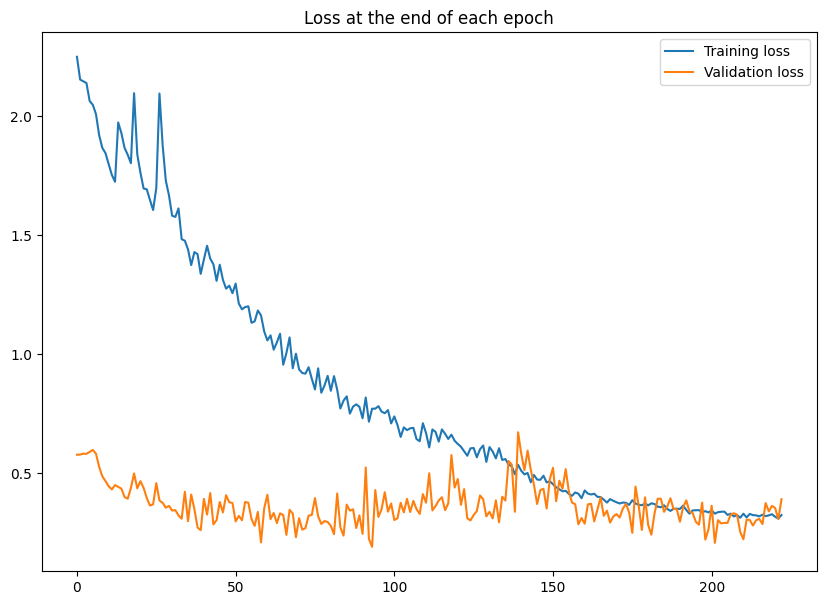

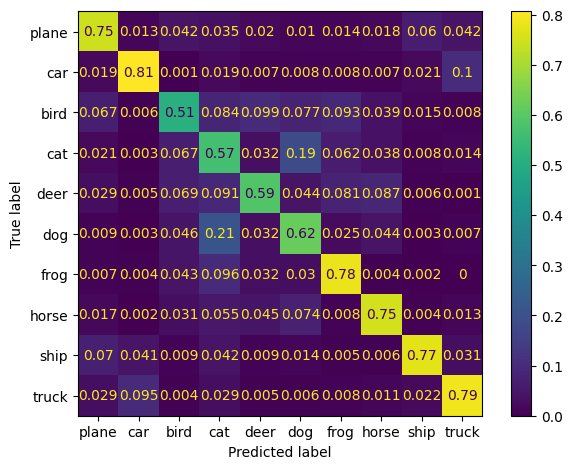

In [17]:
# plot losses
plt.figure(figsize=(10, 7))
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.title('Loss at the end of each epoch')
plt.legend()
plt.show()

# plot confusion matrix
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

        y_true.append(labels.cpu().numpy())
        y_pred.append(predicted.cpu().numpy())
    
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot()
    plt.tight_layout()
    plt.show()


Test Accuracy: 69.36%


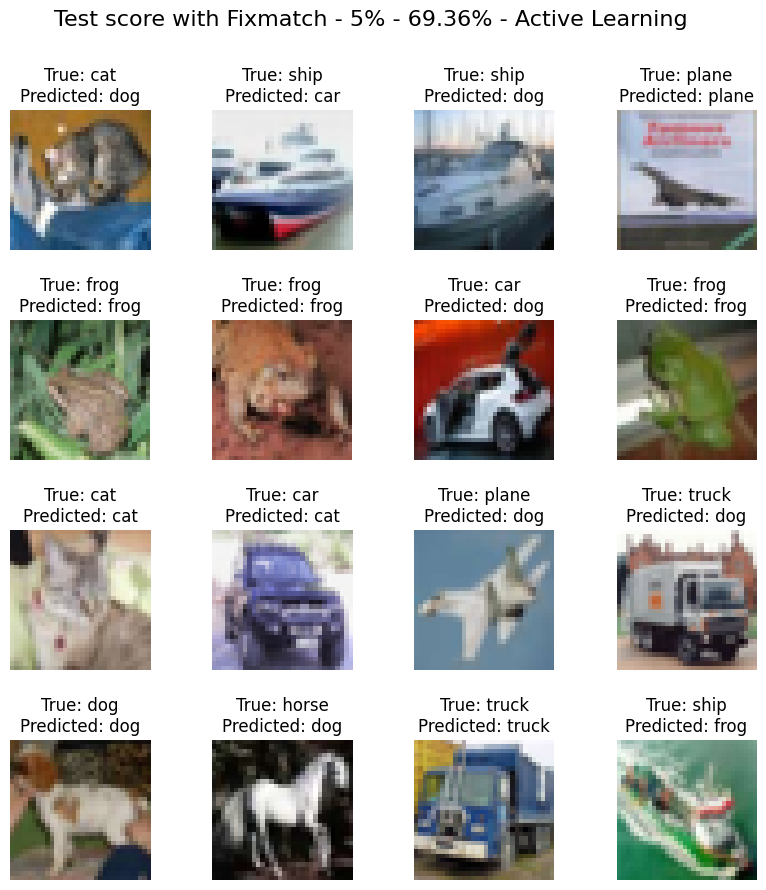

In [18]:
# Evaluation on the test set
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

test_accuracy = 100.0 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy}%')

# save the model
torch.save(model.state_dict(), f"{torch_models}/model_10_fixmatch_AL.pth")

test_image, test_labels = testloader.__iter__().__next__()
test_image = test_image.to(device)
outputs_test = model(test_image)
label_pred_test = outputs_test.argmax(dim=1)

# descale the images
test_image = test_image#  * torch.tensor(std, device=device).view(1, 3, 1, 1) + torch.tensor(mean, device=device).view(1, 3, 1, 1)

fig1 = plot_images(test_image, test_labels, label_pred_test, classes, figure_name=f"Test score with Fixmatch - {int(TARGET_PROP*100)}% - {test_accuracy:.2f}% - Active Learning")
fig1.savefig(f"./figures/test_score_{TARGET_PROP}_fixmatch_AL.png")

### III.2 Fixmatch on 5% train data

In [ ]:
# Define your dataset and dataloaders for labeled and unlabeled data
seedEverything()

EPOCHS = 50
SUBSET_PROP = 0.05

# 10% labeled data and 100% unlabeled (see note 2 in paper)
trainset_sup, _ = torch.utils.data.random_split(trainset, [SUBSET_PROP, 1-SUBSET_PROP])

trainset_unsup, _ = torch.utils.data.random_split(trainset, [1, 0])

labeled_dataloader = DataLoader(
    trainset_sup,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

unlabeled_dataloader = DataLoader(
    trainset_unsup,
    batch_size=MU*BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

# transformations
weak_transform = K.ImageSequential(
    K.RandomHorizontalFlip(p=0.50), 
    K.RandomAffine(degrees=0, translate=(0.125, 0.125)),
)

strong_transform = K.ImageSequential(
    K.auto.RandAugment(n=2, m=10), # randaugment + cutout
)

def mask(model, weak_unlabeled_data):
    with torch.no_grad():
        model.train()

        qb = model(weak_unlabeled_data)

        # qb = logits.copy()
        qb = torch.softmax(qb, dim=1)

        max_qb, qb_hat = torch.max(qb, dim=1)

        idx = max_qb > TAU
        qb_hat = qb_hat[idx]

    return qb_hat.detach(), idx, max_qb.detach()

model = ConvNN().to(device)

# criterion and optimizer
labeled_criterion = nn.CrossEntropyLoss(reduction='none')
unlabeled_criterion = nn.CrossEntropyLoss(reduction='none')

optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=BETA, weight_decay=WEIGHT_DECAY, nesterov=True)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)


# Define the cosine learning rate decay function
lr_lambda = lambda step: LR * torch.cos(torch.tensor((7 * torch.pi * (step)) / (16 * EPOCHS))) * 100 / 3

# Create a learning rate scheduler with the cosine decay function
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

# scheduler = None

In [ ]:
print("Start training")

train_losses = []
test_losses = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    running_n_unlabeled = 0
    max_confidence = 0


    pbar = tqdm(zip(labeled_dataloader, unlabeled_dataloader), total=min(len(labeled_dataloader), len(unlabeled_dataloader)), unit="batch", desc=f"Epoch {epoch: >5}")

    for i, (labeled_data, unlabeled_data) in enumerate(pbar):
        # Get labeled and unlabeled data
        labeled_inputs, labels = labeled_data[0].to(device), labeled_data[1].to(device)
        unlabeled_inputs, _ = unlabeled_data[0].to(device), unlabeled_data[1].to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Apply weak augmentation to labeled data
        weak_labeled_inputs = weak_transform(labeled_inputs)

        # Apply strong augmentation + weak augmentation to unlabeled data
        weak_unlabeled_inputs = weak_transform(unlabeled_inputs)
        strong_unlabeled_inputs = strong_transform(unlabeled_inputs)

        # normalize
        weak_labeled_inputs = normalize(data=weak_labeled_inputs, mean=mean, std=std)
        weak_unlabeled_inputs = normalize(data=weak_unlabeled_inputs, mean=mean, std=std)
        strong_unlabeled_inputs = normalize(data=strong_unlabeled_inputs, mean=mean, std=std)

        # Compute mask, confidence
        pseudo_labels, idx, max_qb = mask(model, weak_unlabeled_inputs)
        strong_unlabeled_inputs = strong_unlabeled_inputs[idx]

        n_labeled, n_unlabeled = weak_labeled_inputs.size(0), strong_unlabeled_inputs.size(0)

        if n_unlabeled != 0:
            # Concatenate labeled and unlabeled data
            inputs_all = torch.cat((weak_labeled_inputs, strong_unlabeled_inputs))
            labels_all = torch.cat((labels, pseudo_labels))

            # forward pass
            outputs = model(inputs_all)
            # outputs = torch.softmax(outputs, dim=1)

            # split labeled and unlabeled outputs
            labeled_outputs, unlabeled_outputs = outputs[:n_labeled], outputs[n_labeled:]

            # compute losses
            labeled_loss = torch.sum(labeled_criterion(labeled_outputs, labels)) / BATCH_SIZE
            unlabeled_loss = torch.sum(unlabeled_criterion(unlabeled_outputs, pseudo_labels)) / (MU * BATCH_SIZE)

            # compute total loss
            loss = labeled_loss + LAMBDA_U * unlabeled_loss

            # compute accuracy
            total += labels_all.size(0)
            correct += (outputs.argmax(dim=1) == labels_all).sum().item()
            
        else:
            # forward pass
            labeled_outputs = model(weak_labeled_inputs)
            # labeled_outputs = torch.softmax(labeled_outputs, dim=1)

            # compute loss
            labeled_loss = torch.sum(labeled_criterion(labeled_outputs, labels)) / BATCH_SIZE
            unlabeled_loss = torch.tensor(0, device=device)

            # compute total loss
            loss = labeled_loss + LAMBDA_U * unlabeled_loss

            # compute accuracy
            total += labels.size(0)
            correct += (labeled_outputs.argmax(dim=1) == labels).sum().item()


        # backward pass + optimize
        loss.backward()
        optimizer.step()

        

        # update statistics
        running_loss += loss.item()
        running_n_unlabeled += n_unlabeled
        max_confidence = max(max_confidence, max_qb.max().item())

        

        # update progress bar
        pbar.set_postfix({
            "total loss": loss.item(),
            "labeled loss": labeled_loss.item(),
            "unlabeled loss": unlabeled_loss.item(),
            "accuracy": 100 * correct / total,
            "confidence": max_confidence,
            "n_unlabeled": running_n_unlabeled,
            "lr": optimizer.param_groups[0]['lr'].item()
        })

    # update loss
    train_losses.append(running_loss / (i + 1))

    # scheduler step
    if scheduler is not None:
        scheduler.step()

    
    # Evaluate the model on the test set
    model.eval()  # Set the model to evaluation mode
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # normalize
            images = normalize(data=images, mean=mean, std=std)
            
            outputs = model(images)
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()
        
        test_accuracy = 100.0 * test_correct / test_total
        print(f'Test Accuracy: {test_accuracy}%')

        # update loss
        test_losses.append(torch.sum(labeled_criterion(outputs, labels)).item() / BATCH_SIZE)


In [ ]:
# plot losses
plt.figure(figsize=(10, 7))
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.title('Loss at the end of each epoch')
plt.legend()
plt.show()

# plot confusion matrix
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

        y_true.append(labels.cpu().numpy())
        y_pred.append(predicted.cpu().numpy())
    
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot()
    plt.tight_layout()
    plt.show()


In [ ]:
# Evaluation on the test set
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

test_accuracy = 100.0 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy}%')

# save the model
torch.save(model.state_dict(), f"{torch_models}/model_5_fixmatch.pth")

test_image, test_labels = testloader.__iter__().__next__()
test_image = test_image.to(device)
outputs_test = model(test_image)
label_pred_test = outputs_test.argmax(dim=1)

# descale the images
test_image = test_image#  * torch.tensor(std, device=device).view(1, 3, 1, 1) + torch.tensor(mean, device=device).view(1, 3, 1, 1)

fig1 = plot_images(test_image, test_labels, label_pred_test, classes, figure_name=f"Test score with Fixmatch - {int(SUBSET_PROP*100)}% - {test_accuracy:.2f}%")
fig1.savefig(f"./figures/test_score_{SUBSET_PROP}_fixmatch.png")

### III.3 Fixmatch on 1% train data

In [ ]:
# Define your dataset and dataloaders for labeled and unlabeled data
seedEverything()

EPOCHS = 50
SUBSET_PROP = 0.01

# 10% labeled data and 100% unlabeled (see note 2 in paper)
trainset_sup, _ = torch.utils.data.random_split(trainset, [SUBSET_PROP, 1-SUBSET_PROP])

trainset_unsup, _ = torch.utils.data.random_split(trainset, [1, 0])

labeled_dataloader = DataLoader(
    trainset_sup,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

unlabeled_dataloader = DataLoader(
    trainset_unsup,
    batch_size=MU*BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

# transformations
weak_transform = K.ImageSequential(
    K.RandomHorizontalFlip(p=0.50), 
    K.RandomAffine(degrees=0, translate=(0.125, 0.125)),
)

strong_transform = K.ImageSequential(
    K.auto.RandAugment(n=2, m=10), # randaugment + cutout
)

def mask(model, weak_unlabeled_data):
    with torch.no_grad():
        model.train()

        qb = model(weak_unlabeled_data)

        # qb = logits.copy()
        qb = torch.softmax(qb, dim=1)

        max_qb, qb_hat = torch.max(qb, dim=1)

        idx = max_qb > TAU
        qb_hat = qb_hat[idx]

    return qb_hat.detach(), idx, max_qb.detach()

model = ConvNN().to(device)

# criterion and optimizer
labeled_criterion = nn.CrossEntropyLoss(reduction='none')
unlabeled_criterion = nn.CrossEntropyLoss(reduction='none')

optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=BETA, weight_decay=WEIGHT_DECAY, nesterov=True)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)


# Define the cosine learning rate decay function
lr_lambda = lambda step: LR * torch.cos(torch.tensor((7 * torch.pi * (step)) / (16 * EPOCHS))) * 100 / 3

# Create a learning rate scheduler with the cosine decay function
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

# scheduler = None

In [ ]:
print("Start training")

train_losses = []
test_losses = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    running_n_unlabeled = 0
    max_confidence = 0


    pbar = tqdm(zip(labeled_dataloader, unlabeled_dataloader), total=min(len(labeled_dataloader), len(unlabeled_dataloader)), unit="batch", desc=f"Epoch {epoch: >5}")

    for i, (labeled_data, unlabeled_data) in enumerate(pbar):
        # Get labeled and unlabeled data
        labeled_inputs, labels = labeled_data[0].to(device), labeled_data[1].to(device)
        unlabeled_inputs, _ = unlabeled_data[0].to(device), unlabeled_data[1].to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Apply weak augmentation to labeled data
        weak_labeled_inputs = weak_transform(labeled_inputs)

        # Apply strong augmentation + weak augmentation to unlabeled data
        weak_unlabeled_inputs = weak_transform(unlabeled_inputs)
        strong_unlabeled_inputs = strong_transform(unlabeled_inputs)

        # normalize
        weak_labeled_inputs = normalize(data=weak_labeled_inputs, mean=mean, std=std)
        weak_unlabeled_inputs = normalize(data=weak_unlabeled_inputs, mean=mean, std=std)
        strong_unlabeled_inputs = normalize(data=strong_unlabeled_inputs, mean=mean, std=std)

        # Compute mask, confidence
        pseudo_labels, idx, max_qb = mask(model, weak_unlabeled_inputs)
        strong_unlabeled_inputs = strong_unlabeled_inputs[idx]

        n_labeled, n_unlabeled = weak_labeled_inputs.size(0), strong_unlabeled_inputs.size(0)

        if n_unlabeled != 0:
            # Concatenate labeled and unlabeled data
            inputs_all = torch.cat((weak_labeled_inputs, strong_unlabeled_inputs))
            labels_all = torch.cat((labels, pseudo_labels))

            # forward pass
            outputs = model(inputs_all)
            # outputs = torch.softmax(outputs, dim=1)

            # split labeled and unlabeled outputs
            labeled_outputs, unlabeled_outputs = outputs[:n_labeled], outputs[n_labeled:]

            # compute losses
            labeled_loss = torch.sum(labeled_criterion(labeled_outputs, labels)) / BATCH_SIZE
            unlabeled_loss = torch.sum(unlabeled_criterion(unlabeled_outputs, pseudo_labels)) / (MU * BATCH_SIZE)

            # compute total loss
            loss = labeled_loss + LAMBDA_U * unlabeled_loss

            # compute accuracy
            total += labels_all.size(0)
            correct += (outputs.argmax(dim=1) == labels_all).sum().item()
            
        else:
            # forward pass
            labeled_outputs = model(weak_labeled_inputs)
            # labeled_outputs = torch.softmax(labeled_outputs, dim=1)

            # compute loss
            labeled_loss = torch.sum(labeled_criterion(labeled_outputs, labels)) / BATCH_SIZE
            unlabeled_loss = torch.tensor(0, device=device)

            # compute total loss
            loss = labeled_loss + LAMBDA_U * unlabeled_loss

            # compute accuracy
            total += labels.size(0)
            correct += (labeled_outputs.argmax(dim=1) == labels).sum().item()


        # backward pass + optimize
        loss.backward()
        optimizer.step()

        

        # update statistics
        running_loss += loss.item()
        running_n_unlabeled += n_unlabeled
        max_confidence = max(max_confidence, max_qb.max().item())

        

        # update progress bar
        pbar.set_postfix({
            "total loss": loss.item(),
            "labeled loss": labeled_loss.item(),
            "unlabeled loss": unlabeled_loss.item(),
            "accuracy": 100 * correct / total,
            "confidence": max_confidence,
            "n_unlabeled": running_n_unlabeled,
            "lr": optimizer.param_groups[0]['lr'].item()
        })

    # update loss
    train_losses.append(running_loss / (i + 1))

    # scheduler step
    if scheduler is not None:
        scheduler.step()

    
    # Evaluate the model on the test set
    model.eval()  # Set the model to evaluation mode
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # normalize
            images = normalize(data=images, mean=mean, std=std)
            
            outputs = model(images)
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()
        
        test_accuracy = 100.0 * test_correct / test_total
        print(f'Test Accuracy: {test_accuracy}%')

        # update loss
        test_losses.append(torch.sum(labeled_criterion(outputs, labels)).item() / BATCH_SIZE)


In [ ]:
# plot losses
plt.figure(figsize=(10, 7))
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.title('Loss at the end of each epoch')
plt.legend()
plt.show()

# plot confusion matrix
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

        y_true.append(labels.cpu().numpy())
        y_pred.append(predicted.cpu().numpy())
    
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot()
    plt.tight_layout()
    plt.show()


In [ ]:
# Evaluation on the test set
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

test_accuracy = 100.0 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy}%')

# save the model
torch.save(model.state_dict(), f"{torch_models}/model_1_fixmatch.pth")

test_image, test_labels = testloader.__iter__().__next__()
test_image = test_image.to(device)
outputs_test = model(test_image)
label_pred_test = outputs_test.argmax(dim=1)

# descale the images
test_image = test_image#  * torch.tensor(std, device=device).view(1, 3, 1, 1) + torch.tensor(mean, device=device).view(1, 3, 1, 1)

fig1 = plot_images(test_image, test_labels, label_pred_test, classes, figure_name=f"Test score with Fixmatch - {int(SUBSET_PROP*100)}% - {test_accuracy:.2f}%")
fig1.savefig(f"./figures/test_score_{SUBSET_PROP}_fixmatch.png")